In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results                 


#Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute('SELECT max(date) FROM measurement').fetchone()
print (last_date)
oneyearago = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
print (oneyearago)

# Perform a query to retrieve the data and precipitation scores
year_precipitation=(session.query(measurement.date,func.max(measurement.prcp))
                  .filter(func.strftime('%Y-%m-%d',measurement.date) > oneyearago)
                  .group_by(measurement.date).all())
print (year_precipitation)


('2017-08-23',)
2016-08-23
[('2016-08-24', 2.28), ('2016-08-25', 0.21), ('2016-08-26', 0.04), ('2016-08-27', 0.18), ('2016-08-28', 2.07), ('2016-08-29', 0.9), ('2016-08-30', 0.05), ('2016-08-31', 2.46), ('2016-09-01', 0.02), ('2016-09-02', 0.19), ('2016-09-03', 1.0), ('2016-09-04', 0.74), ('2016-09-05', 0.18), ('2016-09-06', 1.0), ('2016-09-07', 1.35), ('2016-09-08', 0.22), ('2016-09-09', 0.35), ('2016-09-10', 1.16), ('2016-09-11', 0.6), ('2016-09-12', 1.04), ('2016-09-13', 1.2), ('2016-09-14', 6.7), ('2016-09-15', 3.35), ('2016-09-16', 0.61), ('2016-09-17', 0.36), ('2016-09-18', 0.42), ('2016-09-19', 0.25), ('2016-09-20', 0.43), ('2016-09-21', 1.02), ('2016-09-22', 0.75), ('2016-09-23', 0.94), ('2016-09-24', 0.27), ('2016-09-25', 0.04), ('2016-09-26', 1.02), ('2016-09-27', 1.0), ('2016-09-28', 0.08), ('2016-09-29', 1.49), ('2016-09-30', 0.38), ('2016-10-01', 1.02), ('2016-10-02', 0.61), ('2016-10-03', 0.46), ('2016-10-04', 3.46), ('2016-10-05', 0.81), ('2016-10-06', 0.07), ('2016-10-0

In [60]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(year_precipitation, columns=['date', 'prcp'])
precipitation_df = precipitation_df.rename(columns={"prcp":"Precipitation", "date":"Date"})
precipitation_df.set_index('Date',inplace=True)

# Sort the dataframe by date
precipitation_df.sort_values('Date')
precipitation_df.head(10)

,Precipitation
Date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46
2016-09-01,0.02


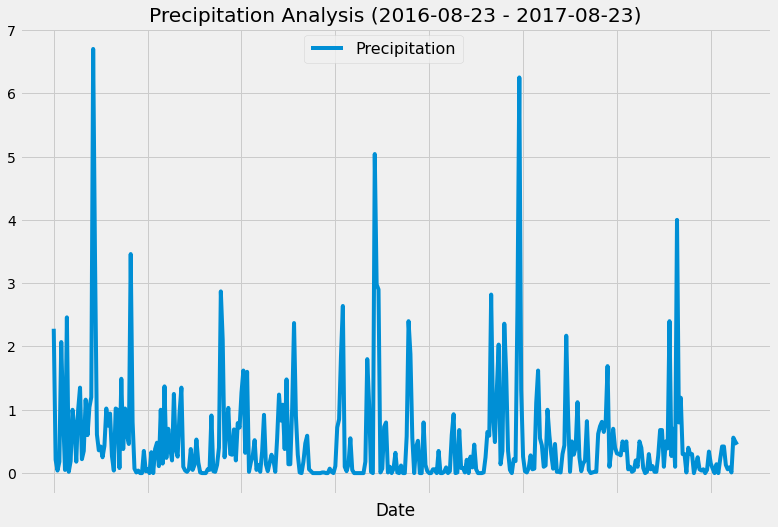

In [61]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(.6,1.001), fontsize="16")
ax.set_title(f"Precipitation Analysis ({(last_12mnth)} - {last_date[0]})")
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_xlabel('Date')
plt.show()

In [62]:
# Use Pandas to calculate the summary statistics for the precipitation data

precipitation_df.describe()

,Precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [64]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(station.id).count()
print (total_stations)

9


In [73]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations=(session.query(measurement.station,func.count(measurement.station))
                         .group_by(measurement.station)
                         .order_by(func.count(measurement.station).desc())
                         .all())
print (active_stations)
    




[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [92]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

tobs=[measurement.station, 
             func.min(measurement.tobs), 
             func.max(measurement.tobs), 
             func.avg(measurement.tobs)]
tobs

most_active_st=(session.query(*tobs)
                       .filter(measurement.station=='USC00519281')
                       .all())
most_active_st

most_active_st_temp=pd.DataFrame(most_active_st, columns=['Station', 'Min_Temp', 
                                                          'Max_temp', 'Avg_temp'])
most_active_st_temp.set_index('Station', inplace=True)
most_active_st_temp

,Min_Temp,Max_temp,Avg_temp
Station,,,
USC00519281,54.0,85.0,71.663781


In [98]:
# Choose the station with the highest number of temperature observations.

high_temp_observ = session.query(measurement.tobs).\
              filter(measurement.station==most_active_station[0][0]).\
                                filter(measurement.date >= last_12mnth).\
                                order_by(measurement.date.desc()).all()
high_temp_observ_df = pd.DataFrame(high_temp_observ)
high_temp_observ_df.head()

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


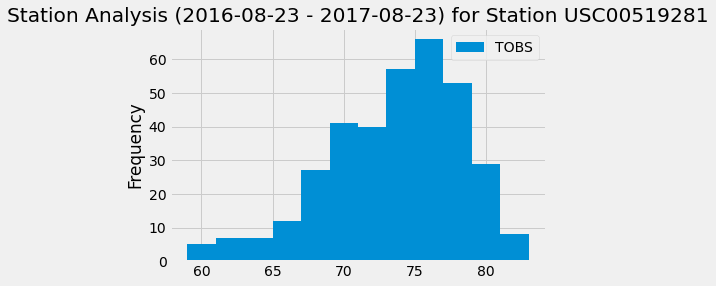

In [99]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(high_temp_observ_df['tobs'], bins=12)
plt.ylabel("Frequency")
plt.title(f"Station Analysis ({(last_12mnth)} - {last_date[0]}) for Station { most_active_station[0][0]}")
plt.legend(["TOBS"])
plt.show()

## Bonus Challenge Assignment